In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse.csgraph as csg
from itertools import combinations
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VARResults

In [3]:
start_date='2014-07-01'
end_date='2024-07-01'

SPY_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
EWI_data = yf.download('EWI', start=start_date, end=end_date)['Adj Close']
EWC_data = yf.download('EWC', start=start_date, end=end_date)['Adj Close']
EWA_data = yf.download('EWA', start=start_date, end=end_date)['Adj Close']
FXI_data = yf.download('FXI', start=start_date, end=end_date)['Adj Close']
EEM_data = yf.download('EEM', start=start_date, end=end_date)['Adj Close']
VGK_data = yf.download('VGK', start=start_date, end=end_date)['Adj Close']

dfs=[SPY_data,EWI_data,EWC_data,EWA_data,FXI_data,EEM_data,VGK_data]
df=pd.concat(dfs,axis=1)
df.columns=['SPY','EWI','EWC','EWA','FXI','EEM','VGK']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


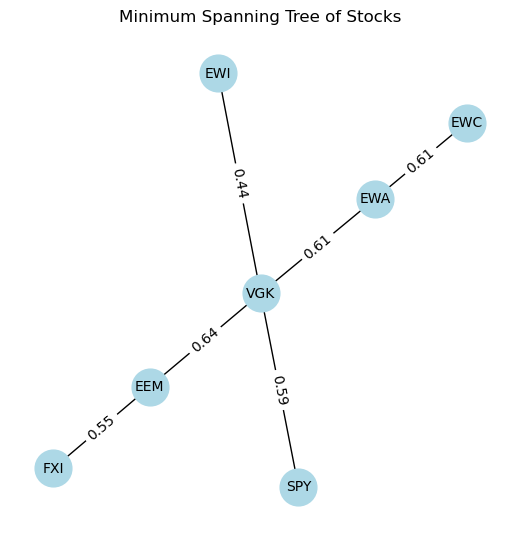

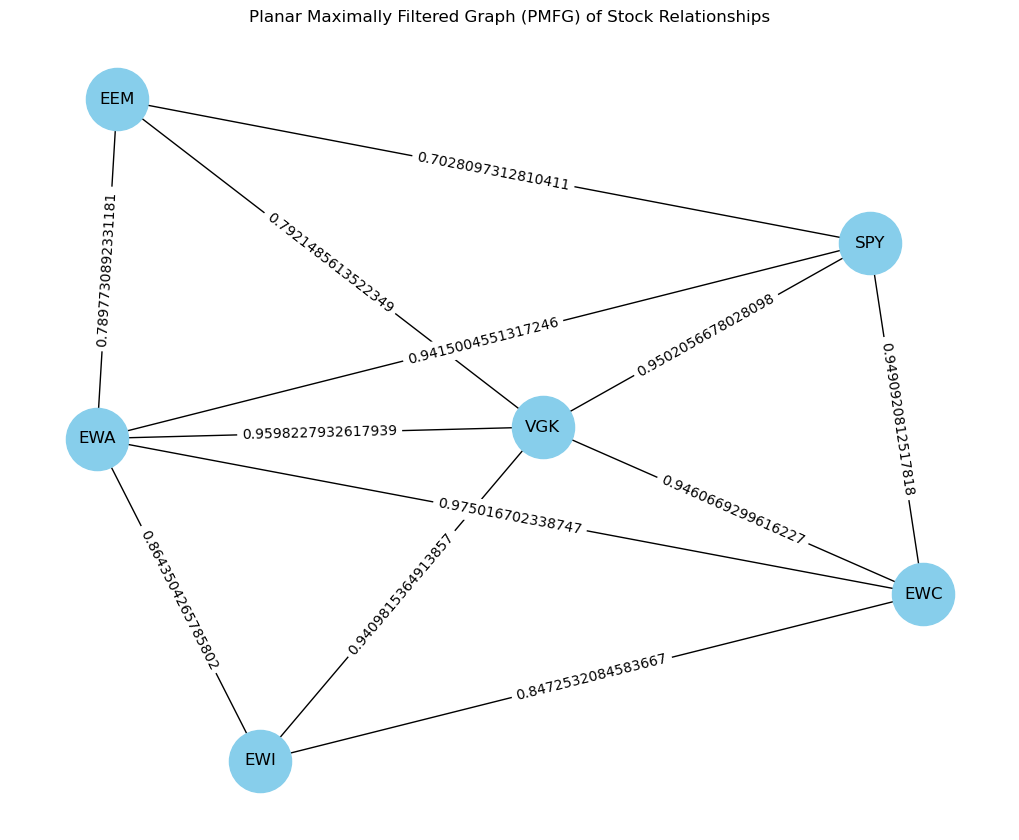

In [4]:
#MST
#define matrix
returns=df.pct_change().dropna()
correlation_matrix=returns.corr()
distance_matrix=np.sqrt(2*(1-correlation_matrix))
condensed_matrix=ssd.squareform(distance_matrix,checks=False)
linkage_matrix=sch.linkage(condensed_matrix,method='single')
mst = csg.minimum_spanning_tree(distance_matrix).toarray()

#Create the graph
G = nx.Graph()

#Add edges and nodes
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if mst[i, j] > 0:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j], weight=mst[i, j])

#Draw
pos = nx.spring_layout(G)  # Positions for all nodes
plt.figure(figsize=(5, 5))
nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_color="black")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f}" for u, v, d in G.edges(data='weight')})
plt.title('Minimum Spanning Tree of Stocks')
plt.show()



#PMFG
corr_matrix = df.corr()

#Create graph with edges
G = nx.Graph()

#Add nodes
stocks = corr_matrix.index
G.add_nodes_from(stocks)

#Add edges based on threshold
for stock1, stock2 in combinations(stocks, 2):
    correlation = corr_matrix.loc[stock1, stock2]
    if abs(correlation) >= 0.6:
        G.add_edge(stock1, stock2, weight=correlation)

#Create graph
pmfg_graph = nx.Graph()

#Check if adding an edge maintains planarity
def can_add_edge(pmfg, u, v):
    if len(pmfg.edges()) <= 2:
        return True
    
    pmfg.add_edge(u, v)
    result = nx.check_planarity(pmfg)[0]
    pmfg.remove_edge(u, v)
    return result

#Sort edges by weight in descending order
edges_sorted = sorted(G.edges(data=True), key=lambda x: -x[2]['weight'])

#Construct PMFG
for u, v, d in edges_sorted:
    if can_add_edge(pmfg_graph, u, v):
        pmfg_graph.add_edge(u, v, weight=d['weight'])

#Draw
pos = nx.spring_layout(pmfg_graph)  # Layout for visualization

plt.figure(figsize=(10, 8))
nx.draw(pmfg_graph, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, font_color='black')
edge_labels = nx.get_edge_attributes(pmfg_graph, 'weight')
nx.draw_networkx_edge_labels(pmfg_graph, pos, edge_labels=edge_labels)
plt.title('Planar Maximally Filtered Graph (PMFG) of Stock Relationships')
plt.show()


In [5]:
#TIC

model = VAR(df)
results = model.fit(maxlags=2, ic='aic')

cov_matrix = np.cov(results.resid)

off_diag_elements = cov_matrix[np.triu_indices_from(cov_matrix, k=1)]
total_sum = np.sum(cov_matrix ** 2)
TCI = np.sum(off_diag_elements ** 2) / total_sum

print(f"Total Connectedness Index (TCI): {TCI:.4f}")

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Total Connectedness Index (TCI): 0.4980


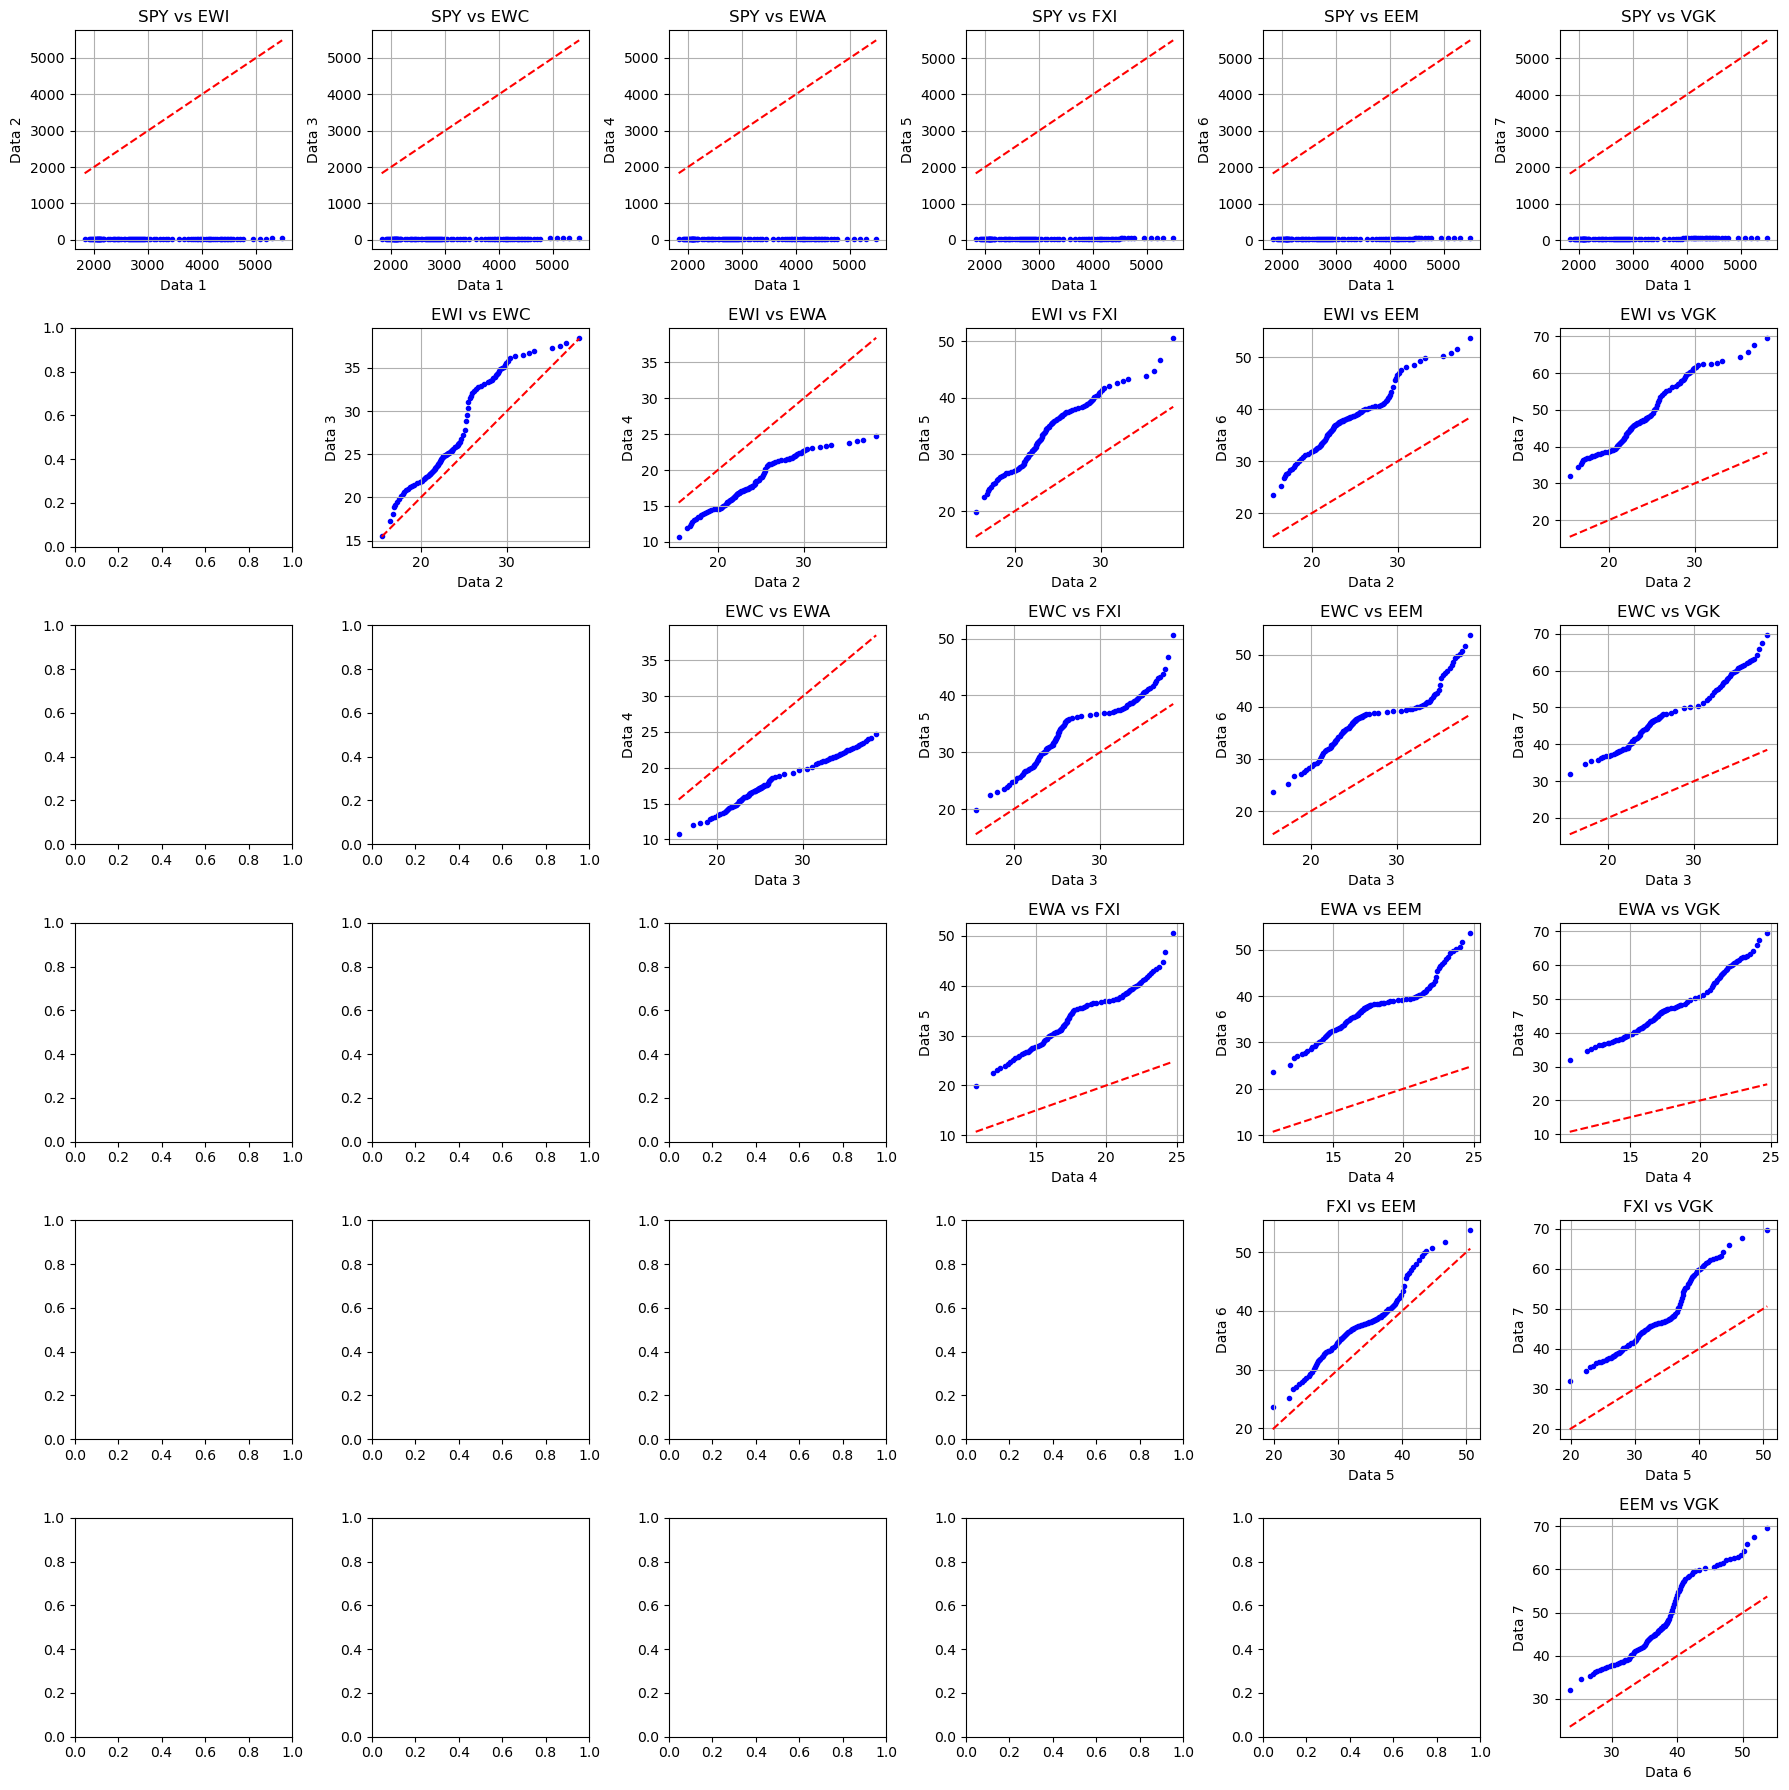

In [6]:
#Q-Q framework
column_labels=['SPY','EWI','EWC','EWA','FXI','EEM','VGK']
quantiles = np.percentile(df, np.linspace(0, 100, 101), axis=0)

# Create Q-Q plots for each pair of datasets
fig, axs = plt.subplots(6, 6, figsize=(18, 18))

for i in range(6):
    for j in range(i+1,7):
        axs[i, j-1].scatter(quantiles[:, i], quantiles[:, j], marker='.', color='b')
        axs[i, j-1].plot(quantiles[:, i], quantiles[:, i], color='r', linestyle='--') #Diagonal
        axs[i, j-1].set_xlabel(f'Data {i+1}')
        axs[i, j-1].set_ylabel(f'Data {j+1}')
        axs[i, j-1].grid(True)
        axs[i, j-1].set_title(f'{column_labels[i]} vs {column_labels[j]}')

plt.tight_layout()
plt.show()

In [ ]:
#TVP-VAR

def fit_tvp_varmax(data, lags=2):
    model = VARMAX(data, order=(lags, 0))  # VARMAX with 0 for exogenous variables (if none)
    results = model.fit(maxiter=1000, disp=False)  # Adjust parameters as needed
    return results

varmax_model=fit_tvp_varmax(df)

def forecast_tvp_var(model, steps=50):
    forecast=model.forecast(steps)  # Forecast 'steps' periods ahead
    return forecast

forecast_steps=50
forecast=forecast_tvp_var(varmax_model, steps=forecast_steps)
print(f"Forecast for the next {forecast_steps} periods:")
print(forecast)

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [ ]:
#TIC

model=VAR(forecast)
results=model.fit(maxlags=2, ic='aic')

cov_matrix=np.cov(results.resid)

off_diag_elements=cov_matrix[np.triu_indices_from(cov_matrix, k=1)]
total_sum=np.sum(cov_matrix ** 2)
TCI=np.sum(off_diag_elements ** 2)/total_sum

print(f"Total Connectedness Index (TCI): {TCI:.4f}")